In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from IPython.display import display, HTML

NOTAS = 'C:\\Users\\cpcle\\OneDrive\\Documentos\\Celso\\Python\\veneta-dash\\data\\Notas.pkl'

CADASTRO = 'C:\\Users\\cpcle\\OneDrive\\Documentos\\Celso\\Veneta\\Dados Winbooks\\Despesas e Custos\\Cadastro de Produtos.xlsx'

TABELA = 'C:\\Users\\cpcle\\OneDrive\\Documentos\\Celso\\Python\\veneta-dash\\data\\Tabela_Veneta_2020.xlsx'


In [25]:
nt = pd.read_pickle(NOTAS)

nt = nt[(nt['Emissao'] >= '2020') &
        (nt['Emissao'] <  '2022') &
        (nt['Grupo'] == 'Amazon')]

In [26]:
resumo = nt.groupby(pd.Grouper(key='Emissao', freq='MS'))\
    [['Receita Líquida']].sum().reset_index()

resumo['Mês'] = resumo['Emissao'].dt.month
resumo['Ano'] = resumo['Emissao'].dt.year

resumo = resumo.pivot(index=['Mês'],
                      columns=['Ano'],
                      values=['Receita Líquida'])

# Comparativo do Volume de Compras de Amazon (2021 x 2020)

### 1. Evolutivo das Compras Acumuladas da Amazon (2020 x 2021)

As compras da Amazon em 2021 tem sido constantemente inferiores àquelas realizadas em 2020, apesar de termos lançado mais livros neste ano.

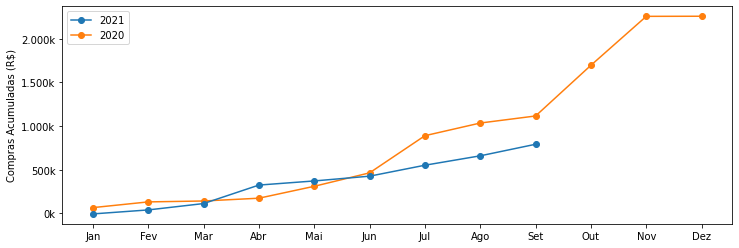

In [27]:
# Acumulado de Vendas
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 1, 1)

x = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
     'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

y = resumo.iloc[:, 1].cumsum()
ax1.plot(x, y, label=resumo.columns[1][1], marker='o')
y = resumo.iloc[:, 0].cumsum()
line = ax1.plot(x, y, label=resumo.columns[0][1], marker='o', zorder=0)
#ax1.fill_between(x, 0, y, alpha=0.3, color=line[0].get_color())

ax1.set_ylabel('Compras Acumuladas (R$)')
# ax1.set_title('Evolutivo Mensal das Compras Amazon')
ax1.yaxis.set_major_formatter(FuncFormatter(
    lambda x, pos: '{:,.0f}k'.format(x/1000).replace(',', '.')
))
ax1.legend()
plt.show()

### 2. Evolutivo Mensal das Compras da Amazon

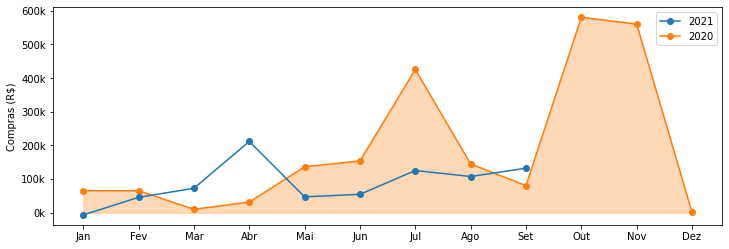

In [28]:
# Evolutivo Mensal das Vendas
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 1, 1)

x = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
     'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

y = resumo.iloc[:, 1]
ax1.plot(x, y, label=resumo.columns[1][1], marker='o')
y = resumo.iloc[:, 0]
line = ax1.plot(x, y, label=resumo.columns[0][1], marker='o', zorder=0)
ax1.fill_between(x, 0, y, alpha=0.3, color=line[0].get_color())

ax1.set_ylabel('Compras (R$)')
# ax1.set_title('Evolutivo Mensal das Compras Amazon')
ax1.yaxis.set_major_formatter(FuncFormatter(
    lambda x, pos: '{:,.0f}k'.format(x/1000).replace(',', '.')
))
ax1.legend()
plt.show()

In [29]:
resumo.index = x
dif = resumo[('Receita Líquida', 2020)].sum() - \
      resumo[('Receita Líquida', 2021)].sum() 
    
resumo=resumo.applymap(lambda x: '{:,.0f}k'.format(x/1000)
                .replace('.', '#%')
                .replace(',', '.')
                .replace('#%', ',')
                .replace('nank', '-'))
resumo.transpose().rename(mapper={'Receita Líquida': 'Compras'}, axis=0)


Jan  Fev  Mar   Abr   Mai   Jun   Jul   Ago   Set   Out   Nov  \
        Ano                                                                   
Compras 2020  66k  66k  10k   32k  136k  154k  426k  145k   81k  581k  561k   
        2021  -6k  46k  73k  212k   47k   55k  126k  108k  132k     -     -   

             Dez  
        Ano       
Compras 2020  1k  
        2021   -

### 3. Comparativo do Número de Lançamentos 2020 x 2021

In [30]:
# Lista dos títulos do PNLD
PNLD = ['CAROLINA - 0991L18606130IL',
        'ANGOLA JANGA - 1132L18606130IL',
        'CUMBE - 1146L18606130IL',
        'Angola Janga - 1132L - e-pub',
        'Carolina - 0991L - e-pub',
        'Cumbe - 1146L - e-pub']

# Agrupamento de Títulos
AGRP_TIT = {'9788595710207': ('9788563137203', 'Cumbe'),
            '9788595710214': ('9788563137036', 'A arte de Voar'),
            '9788595710399': ('9788563137586', 'Carolina'),
            '9786586691009': ('9788563137562', 'Matadouro de Unicornios'), }

# Agrupa por Mês
resumo = pd.read_pickle(NOTAS).groupby([pd.Grouper(key='Emissao', freq='MS'), 'Titulo']).aggregate(
    {'Receita Líquida': 'sum', 'Vendas': 'sum'}).reset_index()

# Exclui Títulos do PNLD
resumo = resumo.loc[~resumo['Titulo'].isin(PNLD)]

# Coloca ISBN
resumo = resumo.merge(pd.read_excel(CADASTRO,
                                    usecols='A,D', header=0, dtype=str,
                                    names=['ISBN', 'Titulo']).dropna(),
                      how='left', on='Titulo')

# Substitui títulos das segundas edições
key = resumo['ISBN'].isin(AGRP_TIT.keys())
resumo.loc[key, 'Titulo'] = resumo.loc[key,
                                       'ISBN'].map(lambda x: AGRP_TIT[x][1])
resumo.loc[key, 'ISBN'] = resumo.loc[key, 'ISBN'].map(lambda x: AGRP_TIT[x][0])
del key

# Agrega vendas dos títulos da segunda edição
resumo = resumo.groupby(['ISBN', 'Titulo',
                         pd.Grouper(key='Emissao', freq='MS')])\
            .sum().reset_index()

# Coloca coluna da data de lançamento dos títulos
lanc = resumo.loc[resumo['Vendas'] != 0, :].groupby('ISBN')['Emissao'].idxmin()
lanc = resumo.loc[lanc, ['ISBN', 'Emissao']].rename({'Emissao': 'Lancamento'},
                                                    axis=1)

resumo = resumo.loc[resumo['Vendas'] != 0].merge(lanc, how='left', on='ISBN')\
    .sort_values(['Lancamento', 'ISBN', 'Emissao'])
del lanc

# Coluna para separar Impresso e e-book
resumo['ebook'] = resumo['Titulo'].str.contains('e-?book|e-?pub', case=False)

# Coluna indica se é Lançamento (True) ou Catálogo (False)
resumo['Lanc/Cat'] = ((resumo['Emissao'].dt.year - resumo['Lancamento'].dt.year) * 12 + resumo['Emissao'].dt.month - resumo['Lancamento'].dt.month) < 6

# Cria tabela mensal de Lançamentos
lanc = resumo.groupby(['ebook', 'ISBN'], as_index=False)['Lancamento'].min()\
    .groupby(['ebook', 'Lancamento']).size().to_frame(name='Lançamentos')\
    .pivot_table(index='Lancamento', columns='ebook', aggfunc='sum',
                 fill_value=0)

lanc = lanc.reset_index().groupby(pd.Grouper(key='Lancamento', freq='MS'))[
    [('Lançamentos', False), ('Lançamentos', True)]].sum().reset_index()

lanc = lanc.droplevel(level=0, axis=1)
lanc.columns = ['Emissao', lanc.columns[1], lanc.columns[2]]
lanc['Ano'] = lanc['Emissao'].dt.year
lanc = lanc[lanc['Ano'] >= 2020]
lanc['Mês'] = lanc['Emissao'].dt.month

lanc.rename(mapper={True: 'e-Book', False: 'Impresso'}, axis=1, inplace=True)
lanc = lanc.pivot(index=['Mês'], columns=['Ano'],
                  values=['e-Book', 'Impresso'])

lanc = lanc.swaplevel(axis=1).sort_values(by='Ano', axis=1)


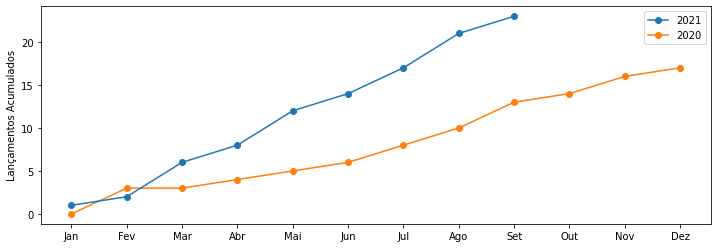

In [31]:
# Cria acumulado de Lançamentos Impressos
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 1, 1)

x = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
     'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

y = lanc.iloc[:, 3].cumsum()
ax1.plot(x, y, label=lanc.columns[3][0], marker='o')
y = lanc.iloc[:, 1].cumsum()
line = ax1.plot(x, y, label=lanc.columns[1][0], marker='o', zorder=0)
#ax1.fill_between(x, 0, y, alpha=0.3, color=line[0].get_color())

ax1.set_ylabel('Lançamentos Acumulados')
# ax1.set_title('Evolutivo Mensal das Compras Amazon')
ax1.yaxis.set_major_formatter(FuncFormatter(
    lambda x, pos: '{:,.0f}'.format(x).replace(',', '.')
))
ax1.legend()
plt.show()


In [32]:
lanc = lanc.append(lanc.sum(axis=0), ignore_index=True)

lanc = lanc.applymap(lambda x: '{:,.0f}'.format(x).replace('nan', '-'))

lanc.index = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
              'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez', 'Total']


In [33]:
display(HTML('<table style="width:80%">' +
             '<thead>' +
             '<tr><th style="text-align:left">2020</th>' +
             '<th style="text-align:left">2021</th></tr>' +
             '</thead>' +
             '<tbody>' +
             '<tr><td>' + lanc[2020].to_html() +
             '</td><td>' + lanc[2021].to_html() + '</td></tr>' +
             '</tbody>' +
             '</table>'))


In [34]:
resumo = nt.groupby(pd.Grouper(key='Emissao', freq='QS'))[
    ['Receita Líquida']].sum().reset_index()

resumo['Ano'] = resumo['Emissao'].dt.year
resumo['Trim'] = resumo['Emissao'].dt.quarter

resumo = resumo.pivot(index=['Trim'],
                      columns=['Ano'],
                      values=['Receita Líquida'])

resumo[('Receita Líquida', 'Var')] = resumo['Receita Líquida'][2021] / \
    resumo['Receita Líquida'][2020] - 1

### 4. Comparativo das Compras Trimestrais (2020 x 2021)

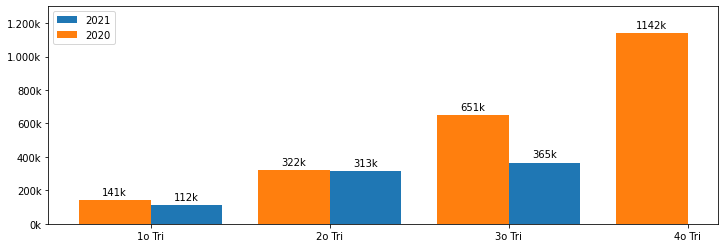

In [35]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 1, 1)

x = list([x + 0.2 for x in range(4)])
y = resumo.iloc[:, 1] / 1000
bar1 = ax1.bar(x, y, label=resumo.columns[1][1], width=0.4)
ax1.bar_label(bar1, padding=3, fmt='%dk')

x = list([x - 0.2 for x in range(4)])
y = resumo.iloc[:, 0] / 1000
bar1 = ax1.bar(x, y, label=resumo.columns[0][1], width=0.4)
ax1.bar_label(bar1, padding=3, fmt='%dk')

ax1.set_ylim(0, 1300)
ax1.set_xticks([0, 1, 2, 3])
ax1.set_xticklabels(['1o Tri', '2o Tri', '3o Tri', '4o Tri'])

ax1.yaxis.set_major_formatter(FuncFormatter(
    lambda x, pos: '{:,.0f}k'.format(x).replace(',', '.')
))

# ax1.set_title('Compras Trimestrais 2021 x 2020')
ax1.legend(loc='upper left')
plt.show()


In [36]:
resumo[('Receita Líquida', 2020)] = resumo[('Receita Líquida', 2020)]\
    .apply(lambda x: '{:,.0f}'.format(x)
           .replace('.', '#%')
           .replace(',', '.')
           .replace('#%', ','))

resumo[('Receita Líquida', 2021)] = resumo[('Receita Líquida', 2021)]\
    .apply(lambda x: '{:,.0f}'.format(x)
           .replace('.', '#%')
           .replace(',', '.')
           .replace('#%', ',')
           .replace('nan', '-'))

resumo[('Receita Líquida', 'Var')] = resumo[('Receita Líquida', 'Var')]\
    .apply(lambda x: '{:,.0%}'.format(x)
           .replace('.', '#%')
           .replace(',', '.')
           .replace('#%', ',')
           .replace('nan%', '-'))

resumo.rename(mapper={'Receita Líquida': 'Compras'}, axis=1)

Compras               
Ano        2020     2021   Var
Trim                          
1       141.741  112.213  -21%
2       322.429  313.870   -3%
3       651.686  365.658  -44%
4     1.142.687        -     -

In [37]:
HTML('Diferença de 2020 para 2021: <b>R$ {:,.0f}k</b>'.format(dif/1000)
      .replace('.', '#%')
      .replace(',', '.')
      .replace('#%', ','))


In [38]:
# Cria tabela de Compras por Mês
vds = pd.read_pickle(NOTAS)

# Coloca ISBN
vds = vds.merge(pd.read_excel(CADASTRO,
                              usecols='A,D', header=0, dtype=str,
                              names=['ISBN', 'Titulo']).dropna(),
                how='left', on='Titulo')

# Substitui títulos das segundas edições
key = vds['ISBN'].isin(AGRP_TIT.keys())
vds.loc[key, 'Titulo'] = vds.loc[key,
                                 'ISBN'].map(lambda x: AGRP_TIT[x][1])
vds.loc[key, 'ISBN'] = vds.loc[key, 'ISBN'].map(lambda x: AGRP_TIT[x][0])
del key

# Coloca coluna da data de lançamento dos títulos
lanc = vds.loc[vds['Vendas'] != 0, :].groupby('ISBN')['Emissao'].idxmin()
lanc = vds.loc[lanc, ['ISBN', 'Emissao']].rename({'Emissao': 'Lancamento'},
                                                    axis=1)

vds = vds.loc[vds['Vendas'] != 0].merge(lanc, how='left', on='ISBN')\
    .sort_values(['Lancamento', 'ISBN', 'Emissao'])
del lanc

# Coluna indica se é Lançamento (True) ou Catálogo (False)
vds['Lanc/Cat'] = ((vds['Emissao'].dt.year - vds['Lancamento'].dt.year)
                      * 12 + vds['Emissao'].dt.month - vds['Lancamento'].dt.month) < 6

# Filtra vendas de 2020 e 2021, da Amazon
vds = vds[(vds['Emissao'] >= '2020') &
          (vds['Emissao'] < '2022') &
          (vds['Grupo'] == 'Amazon')]

# Salva tabela para relatório de títulos
tit = vds.copy()

vds = vds.groupby([pd.Grouper(key='Emissao', freq='MS'),
                   'ISBN', 'Titulo', 'Lanc/Cat'])[['Receita Líquida', 'Vendas']].sum().reset_index()

vds.rename(mapper={True: 'Lançamento', False: 'Catálogo'}, axis=1, inplace=True)

vds['Ano'] = vds['Emissao'].dt.year
vds['Mês'] = vds['Emissao'].dt.month

aux = vds.pivot_table(columns=['Lanc/Cat', 'Ano'], index=['Mês'],
                      values=['Receita Líquida'], aggfunc=sum).rename(mapper={True: 'Lançamento', False: 'Catálogo'}, axis=1).droplevel(level=0, axis=1)


### 5. Compras Mensais (R$) separadas por Catálogo e Lançamentos

In [39]:
df1 = aux.loc[1: 9, 'Catálogo']
df1['Var'] = df1[2021] - df1[2020]
df1['Var Acum'] = df1['Var'].cumsum()
df1['Var Acum%'] = df1['Var'] / df1[2020].cumsum()

df1.index = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
               'Jul', 'Ago', 'Set']

df1[2020] = df1[2020].apply(lambda x: '{:,.0f}'.format(x)
                            .replace('.', '#%')
                            .replace(',', '.')
                            .replace('#%', ',')
                            .replace('nan', '-'))
df1[2021] = df1[2021].apply(lambda x: '{:,.0f}'.format(x)
                            .replace('.', '#%')
                            .replace(',', '.')
                            .replace('#%', ',')
                            .replace('nan', '-'))

df1['Var'] = df1['Var'].apply(lambda x: '{:,.0f}'.format(x)
                            .replace('.', '#%')
                            .replace(',', '.')
                            .replace('#%', ',')
                            .replace('nan', '-'))

df1['Var Acum'] = df1['Var Acum'].apply(lambda x: '{:,.0f}'.format(x)
                              .replace('.', '#%')
                              .replace(',', '.')
                              .replace('#%', ',')
                              .replace('nan', '-'))

df1['Var Acum%'] = df1['Var Acum%'].apply(lambda x: '{:,.0%}'.format(x)
                              .replace('.', '#%')
                              .replace(',', '.')
                              .replace('#%', ',')
                              .replace('nan', '-'))

df2 = aux.loc[1: 9, 'Lançamento']
df2['Var'] = df2[2021] - df2[2020]
df2['Var Acum'] = df2['Var'].cumsum()
df2['Var Acum%'] = df2['Var Acum'] / df2[2020].cumsum()
df2.index = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
             'Jul', 'Ago', 'Set']

df2[2020] = df2[2020].apply(lambda x: '{:,.0f}'.format(x)
                            .replace('.', '#%')
                            .replace(',', '.')
                            .replace('#%', ',')
                            .replace('nan', '-'))
df2[2021] = df2[2021].apply(lambda x: '{:,.0f}'.format(x)
                            .replace('.', '#%')
                            .replace(',', '.')
                            .replace('#%', ',')
                            .replace('nan', '-'))

df2['Var'] = df2['Var'].apply(lambda x: '{:,.0f}'.format(x)
                              .replace('.', '#%')
                              .replace(',', '.')
                              .replace('#%', ',')
                              .replace('nan', '-'))

df2['Var Acum'] = df2['Var Acum'].apply(lambda x: '{:,.0f}'.format(x)
                              .replace('.', '#%')
                              .replace(',', '.')
                              .replace('#%', ',')
                              .replace('nan', '-'))

df2['Var Acum%'] = df2['Var Acum%'].apply(lambda x: '{:,.0%}'.format(x)
                                .replace('.', '#%')
                                .replace(',', '.')
                                .replace('#%', ',')
                                .replace('nan', '-'))


In [40]:
display(HTML('<table style="width:80%">' +
             '<thead>' +
             '<tr><th style="text-align:left">Catálogo</th>' +
             '<th style="text-align:left">Lançamentos</th></tr>' +
             '</thead>' +
             '<tbody>' +
             '<tr><td>' + df1.to_html() +
             '</td><td>' + df2.to_html() + '</td></tr>' +
             '</tbody>' +
             '</table>'))


### 6. Compras (R$) por Título

#### Somente no período de Lançamento (seis meses após o lançamento)

In [41]:
x = tit[(tit['Emissao'].dt.year >= 2020) &
        tit['Lanc/Cat']]\
    .pivot_table(index=['Titulo', 'Lancamento'],
                 columns=pd.Grouper(key='Emissao', freq='QS'),
                 values=['Receita Líquida'],
                 aggfunc=sum).sort_values('Lancamento')

x = x.droplevel(level=0, axis=1)
x.loc[('Total', ''), :] = x.sum()

x.columns = ['2020 - Q1', '2020 - Q2', '2020 - Q3', '2020 - Q4',
             '2021 - Q1', '2021 - Q2', '2021 - Q3']

x.applymap(lambda x: '{:,.0f}'.format(x)
                              .replace('.', '#%')
                              .replace(',', '.')
                              .replace('#%', ',')
                              .replace('nan', '-'))


,,2020 - Q1,2020 - Q2,2020 - Q3,2020 - Q4,2021 - Q1,2021 - Q2,2021 - Q3
Titulo,Lancamento,,,,,,,
UMA HISTORIA DA TATUAGEM NO BRASIL,2019-08-20,1.137,-,-,-,-,-,-
A LOUCA DO SAGRADO CORACAO,2019-09-12,11.651,-,-,-,-,-,-
JEANINE,2019-09-18,1.527,-,-,-,-,-,-
GRAMSCI EM QUADRINHOS,2019-10-28,898,-,-,-,-,-,-
O HOMEM SEM TALENTO,2019-10-31,7.623,-,-,-,-,-,-
SPINNING,2019-11-08,2.101,-,-,-,-,-,-
PECORA,2019-12-26,3.054,-,-,-,-,-,-
OS PROTETORES 2,2020-02-04,218,-,53,-,-,-,-
ALEM DE PALOMAR,2020-02-19,11.692,1.699,6.109,-,-,-,-


#### Compras Totais (R$) em 2020 e 2021

In [42]:
lancs = tit.loc[tit['Lanc/Cat'], 'ISBN'].drop_duplicates()

x = tit[(tit['Emissao'].dt.year >= 2020) &
        tit['ISBN'].isin(lancs)]\
    .pivot_table(index=['Titulo', 'Lancamento'],
                 columns=pd.Grouper(key='Emissao', freq='QS'),
                 values=['Receita Líquida'],
                 aggfunc=sum).sort_values('Lancamento')

x.loc[('Total', ''), :] = x.sum()

x.columns = ['2020 - Q1', '2020 - Q2', '2020 - Q3', '2020 - Q4',
             '2021 - Q1', '2021 - Q2', '2021 - Q3']

x.applymap(lambda x: '{:,.0f}'.format(x)
                              .replace('.', '#%')
                              .replace(',', '.')
                              .replace('#%', ',')
                              .replace('nan', '-'))
### 6. Compras (R$) por Título


,,2020 - Q1,2020 - Q2,2020 - Q3,2020 - Q4,2021 - Q1,2021 - Q2,2021 - Q3
Titulo,Lancamento,,,,,,,
UMA HISTORIA DA TATUAGEM NO BRASIL,2019-08-20,1.434,4.204,4.402,5.984,4.154,4.748,3.314
A LOUCA DO SAGRADO CORACAO,2019-09-12,12.662,17.032,24.678,42.195,-,-,1.214
JEANINE,2019-09-18,1.999,2.223,2.313,921,516,1.055,292
GRAMSCI EM QUADRINHOS,2019-10-28,898,1.370,2.178,1.213,1.527,966,359
O HOMEM SEM TALENTO,2019-10-31,7.623,6.659,19.567,39.310,-,8.908,-
SPINNING,2019-11-08,2.101,3.056,4.585,420,764,917,611
PECORA,2019-12-26,3.054,-,503,-,0,225,22
OS PROTETORES 2,2020-02-04,218,-,53,13,27,80,27
ALEM DE PALOMAR,2020-02-19,11.692,1.699,6.109,445,405,1.699,1.214


### 7. Compras (Unidades) por Título

#### Somente no período de Lançamento (seis meses após o lançamento)

In [43]:
x = tit[(tit['Emissao'].dt.year >= 2020) &
        tit['Lanc/Cat']]\
    .pivot_table(index=['Titulo', 'Lancamento'],
                 columns=pd.Grouper(key='Emissao', freq='QS'),
                 values=['Vendas'],
                 aggfunc=sum).sort_values('Lancamento')

x = x.droplevel(level=0, axis=1)
x.loc[('Total', ''), :] = x.sum()

x.columns = ['2020 - Q1', '2020 - Q2', '2020 - Q3', '2020 - Q4',
             '2021 - Q1', '2021 - Q2', '2021 - Q3']

x.applymap(lambda x: '{:,.0f}'.format(x)
                              .replace('.', '#%')
                              .replace(',', '.')
                              .replace('#%', ',')
                              .replace('nan', '-'))


,,2020 - Q1,2020 - Q2,2020 - Q3,2020 - Q4,2021 - Q1,2021 - Q2,2021 - Q3
Titulo,Lancamento,,,,,,,
UMA HISTORIA DA TATUAGEM NO BRASIL,2019-08-20,23,-,-,-,-,-,-
A LOUCA DO SAGRADO CORACAO,2019-09-12,288,-,-,-,-,-,-
JEANINE,2019-09-18,68,-,-,-,-,-,-
GRAMSCI EM QUADRINHOS,2019-10-28,40,-,-,-,-,-,-
O HOMEM SEM TALENTO,2019-10-31,261,-,-,-,-,-,-
SPINNING,2019-11-08,55,-,-,-,-,-,-
PECORA,2019-12-26,136,-,-,-,-,-,-
OS PROTETORES 2,2020-02-04,49,-,12,-,-,-,-
ALEM DE PALOMAR,2020-02-19,289,42,151,-,-,-,-


#### Compras Totais (Unidades) em 2020 e 2021

In [44]:
lancs = tit.loc[tit['Lanc/Cat'], 'ISBN'].drop_duplicates()

x = tit[(tit['Emissao'].dt.year >= 2020) &
        tit['ISBN'].isin(lancs)]\
    .pivot_table(index=['Titulo', 'Lancamento'],
                 columns=pd.Grouper(key='Emissao', freq='QS'),
                 values=['Vendas'],
                 aggfunc=sum).sort_values('Lancamento')

x.loc[('Total', ''), :] = x.sum()

x.columns = ['2020 - Q1', '2020 - Q2', '2020 - Q3', '2020 - Q4',
             '2021 - Q1', '2021 - Q2', '2021 - Q3']

x.applymap(lambda x: '{:,.0f}'.format(x)
                              .replace('.', '#%')
                              .replace(',', '.')
                              .replace('#%', ',')
                              .replace('nan', '-'))


,,2020 - Q1,2020 - Q2,2020 - Q3,2020 - Q4,2021 - Q1,2021 - Q2,2021 - Q3
Titulo,Lancamento,,,,,,,
UMA HISTORIA DA TATUAGEM NO BRASIL,2019-08-20,29,85,89,121,84,96,67
A LOUCA DO SAGRADO CORACAO,2019-09-12,313,421,610,1.043,-,-,30
JEANINE,2019-09-18,89,99,103,41,23,47,13
GRAMSCI EM QUADRINHOS,2019-10-28,40,61,97,54,68,43,16
O HOMEM SEM TALENTO,2019-10-31,261,228,670,1.346,-,305,-
SPINNING,2019-11-08,55,80,120,11,20,24,16
PECORA,2019-12-26,136,-,24,-,0,10,1
OS PROTETORES 2,2020-02-04,49,-,12,3,6,18,6
ALEM DE PALOMAR,2020-02-19,289,42,151,11,10,42,30


In [ ]:
#! jupyter nbconvert --to html  --no-input amazon.ipynb --output-dir=C:\\Users\\cpcle\\OneDrive\\Documentos\\Celso\\Python\\veneta-custo\\html